In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models , layers
from tensorflow.keras.models import load_model
import pickle
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

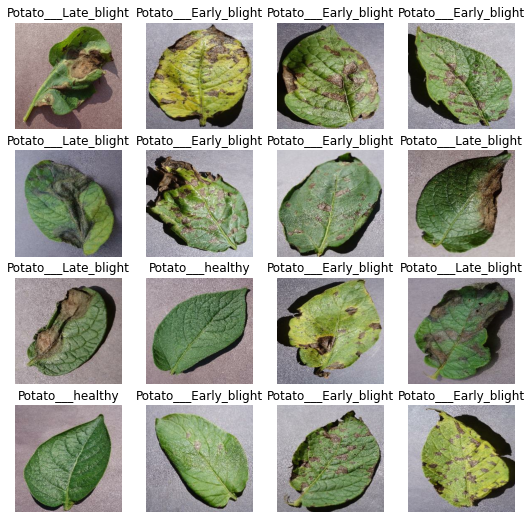

In [6]:
plt.figure(figsize = (9,9))
for image_batch,label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split = 0.1,shuffle=True,shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed= 12)
    
    ds_size = len(ds)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [8]:
train_ds,test_ds,val_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(test_ds)

8

In [11]:
len(val_ds)

6

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmantation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmantation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/30
54/54 [==============================] - 105s 2s/step - loss: 0.8828 - accuracy: 0.5029 - val_loss: 0.7598 - val_accuracy: 0.5677
Epoch 2/30
54/54 [==============================] - 99s 2s/step - loss: 0.6912 - accuracy: 0.6771 - val_loss: 0.5742 - val_accuracy: 0.7396
Epoch 3/30
54/54 [==============================] - 101s 2s/step - loss: 0.4514 - accuracy: 0.8148 - val_loss: 0.3084 - val_accuracy: 0.8490
Epoch 4/30
54/54 [==============================] - 100s 2s/step - loss: 0.3101 - accuracy: 0.8738 - val_loss: 0.1896 - val_accuracy: 0.9427
Epoch 5/30
54/54 [==============================] - 100s 2s/step - loss: 0.1484 - accuracy: 0.9485 - val_loss: 0.1171 - val_accuracy: 0.9479
Epoch 6/30
54/54 [==============================] - 101s 2s/step - loss: 0.1422 - accuracy: 0.9392 - val_loss: 0.2533 - val_accuracy: 0.9271
Epoch 7/30
54/54 [==============================] - 100s 2s/step - loss: 0.1889 - accuracy: 0.9306 - val_loss: 0.1700 - val_accuracy: 0.9427
Epoch 8/30
54/

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 479ms/step - loss: 0.0946 - accuracy: 0.9727


In [20]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [23]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training vs Validation accuracy')

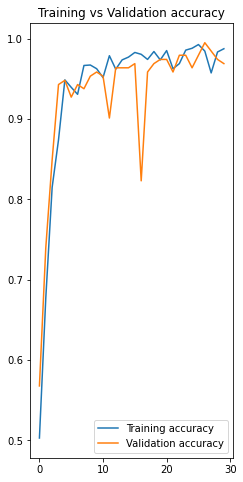

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation accuracy")

Text(0.5, 1.0, 'Training vs Validation loss')

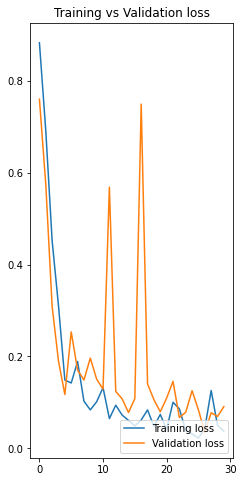

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training vs Validation loss")

In [26]:
history.history

{'loss': [0.882750928401947,
  0.6911705136299133,
  0.4514164626598358,
  0.31007692217826843,
  0.14841003715991974,
  0.14217247068881989,
  0.18891221284866333,
  0.102507084608078,
  0.08359888195991516,
  0.10140020400285721,
  0.13209044933319092,
  0.06464504450559616,
  0.09382378309965134,
  0.07236314564943314,
  0.0608334094285965,
  0.04881878197193146,
  0.0616333894431591,
  0.08352411538362503,
  0.04759615287184715,
  0.07365953177213669,
  0.041288238018751144,
  0.10021377354860306,
  0.08598226308822632,
  0.03912350907921791,
  0.031272370368242264,
  0.022353792563080788,
  0.043328624218702316,
  0.12579263746738434,
  0.049940790981054306,
  0.037291016429662704],
 'accuracy': [0.5028935074806213,
  0.6770833134651184,
  0.8148148059844971,
  0.8738425970077515,
  0.9484953880310059,
  0.9392361044883728,
  0.9305555820465088,
  0.9664351940155029,
  0.9670138955116272,
  0.9623842835426331,
  0.9513888955116272,
  0.9785879850387573,
  0.9618055820465088,
  0.9

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


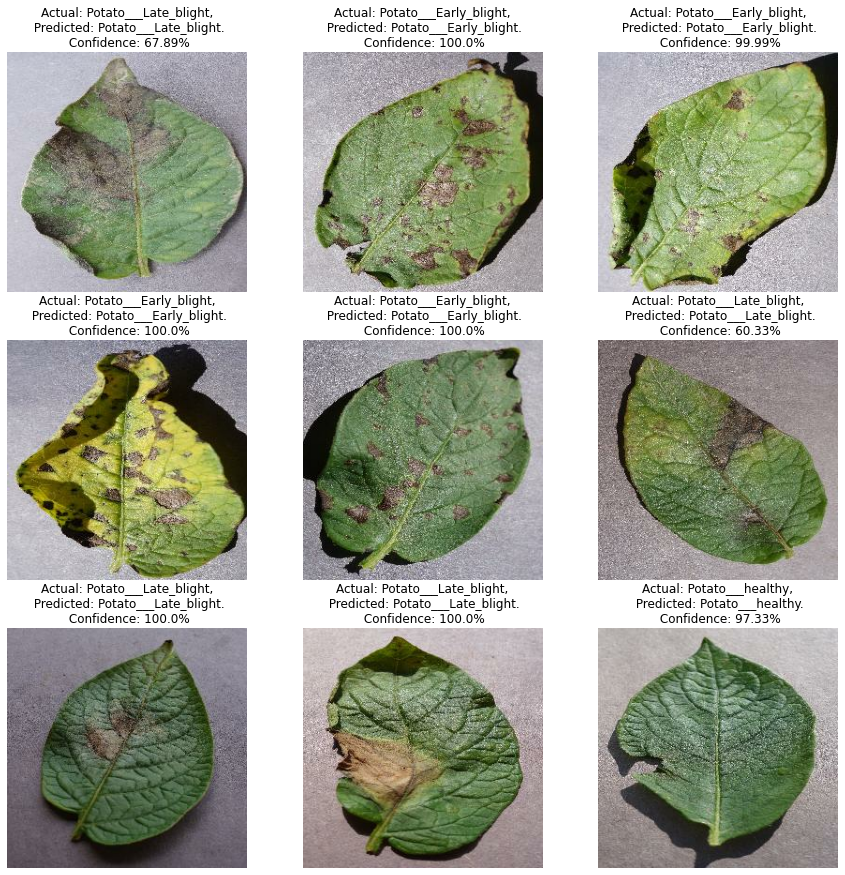

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
model.save(f"../models/1/")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets
